In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, auc, matthews_corrcoef, accuracy_score
from sklearn.pipeline import Pipeline

from xgboost import XGBClassifier

In [2]:
train_df = pd.read_csv('../Data/2020-train.csv')

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 582205 entries, 0 to 582204
Data columns (total 36 columns):
pitcher_id             582205 non-null object
pitcher_side           582205 non-null object
batter_id              582205 non-null object
batter_side            582205 non-null object
stadium_id             582205 non-null object
umpire_id              582205 non-null object
catcher_id             582205 non-null object
inning                 582205 non-null int64
top_bottom             582205 non-null int64
outs                   582053 non-null float64
balls                  582205 non-null int64
strikes                582205 non-null int64
release_speed          582093 non-null float64
vert_release_angle     582093 non-null float64
horz_release_angle     582093 non-null float64
spin_rate              573194 non-null float64
spin_axis              582093 non-null float64
tilt                   580953 non-null object
rel_height             582093 non-null float64
rel_side    

So we're looking at a specific catcher here and his pitch receiving skills, let's pick him out and see how big our data set is.

In [4]:
player_df = train_df[train_df['catcher_id'] == 'f06c9fdf']
player_df

,pitcher_id,pitcher_side,batter_id,batter_side,stadium_id,umpire_id,catcher_id,inning,top_bottom,outs,...,zone_speed,vert_approach_angle,horz_approach_angle,zone_time,x55,y55,z55,pitch_type,pitch_call,pitch_id
35,f4414aa0,Left,f57085ec,Right,43dd6efb,a86853a2,f06c9fdf,9,1,1.0,...,83.303299,-4.02502,0.834138,0.421826,0.759003,55,6.17413,FA,BallCalled,c6607ace
256,ed8aa16f,Right,fbc0970f,Right,45b7bf7c,c229ef9e,f06c9fdf,5,2,0.0,...,78.985100,-8.73613,-0.713829,0.451039,-1.810170,55,6.29071,CH,FoulBall,8ef9aca4
353,0d8afd1d,Left,1813cf1c,Left,d0e0eb76,9c02aab4,f06c9fdf,8,1,0.0,...,73.143700,-9.74545,4.512090,0.483157,2.432580,55,6.46889,CU,FoulBall,b93024dc
397,870b67d9,Right,2d75ea3e,Right,43dd6efb,d057fd71,f06c9fdf,6,1,0.0,...,83.313301,-4.06607,-1.724440,0.413309,-2.126510,55,6.00446,FA,BallCalled,2e4cf21e
418,f58fcfef,Right,277ee019,Right,d0e0eb76,5d49d16c,f06c9fdf,7,1,1.0,...,83.698898,-5.63199,0.283421,0.406953,-1.736550,55,5.69398,FA,FoulBall,b5157dae
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581483,309f3c2d,Right,675b0ce5,Left,d0e0eb76,5d49d16c,f06c9fdf,1,1,1.0,...,90.457703,-4.08045,-1.345470,0.382682,-2.063990,55,5.83140,FA,FoulBall,622c34e4
581503,fe642525,Right,76c0475e,Right,a5ce1bf6,b0106fa5,f06c9fdf,7,2,1.0,...,82.521301,-6.17842,-0.372579,0.417648,-2.032460,55,5.92519,CH,StrikeCalled,ac39f15d
581550,12b0433b,Right,d59d0d36,Left,d0e0eb76,4e713444,f06c9fdf,2,1,0.0,...,78.001503,-6.18036,-0.723831,0.440129,-2.356510,55,6.00084,CH,StrikeSwinging,8040e585
581864,d8352da3,Right,daa1322d,Right,934c75c6,51a1c7ee,f06c9fdf,5,2,0.0,...,86.916801,-4.86654,1.099070,0.393080,-1.019420,55,6.47430,FA,BallCalled,199f7047


8800 data points, not too bad. We can get some good data out of this. Let's see what happened on each of those pitches.

In [5]:
player_df['pitch_call'].value_counts()

BallCalled        3451
InPlay            1516
FoulBall          1460
StrikeCalled      1381
StrikeSwinging     980
HitByPitch          34
Name: pitch_call, dtype: int64

Lots of balls called, not good. Though that could be more on the pitcher that's throwing to him than the catcher himself. Let's put these on a scatter plot to see where all of these pitches crossed the plate.

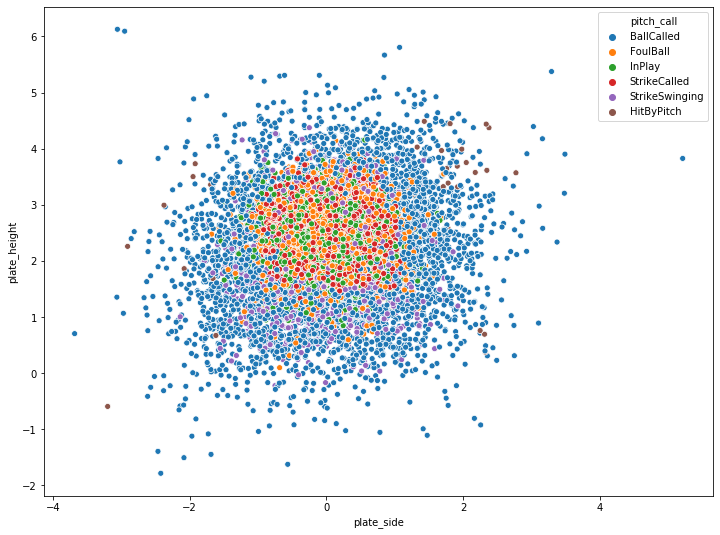

In [6]:
plt.figure(figsize=(12,9))
sns.scatterplot('plate_side', 'plate_height', data=player_df, hue='pitch_call')
plt.show()

That doesn't give a whole lot of information. Since we're looking at pitch receiving skills, let's take a look and called balls and strikes, perhaps we can see how well he's framing pitches.

In [7]:
framing_df = player_df[(player_df['pitch_call'] == 'StrikeCalled') | (player_df['pitch_call'] == 'BallCalled')]

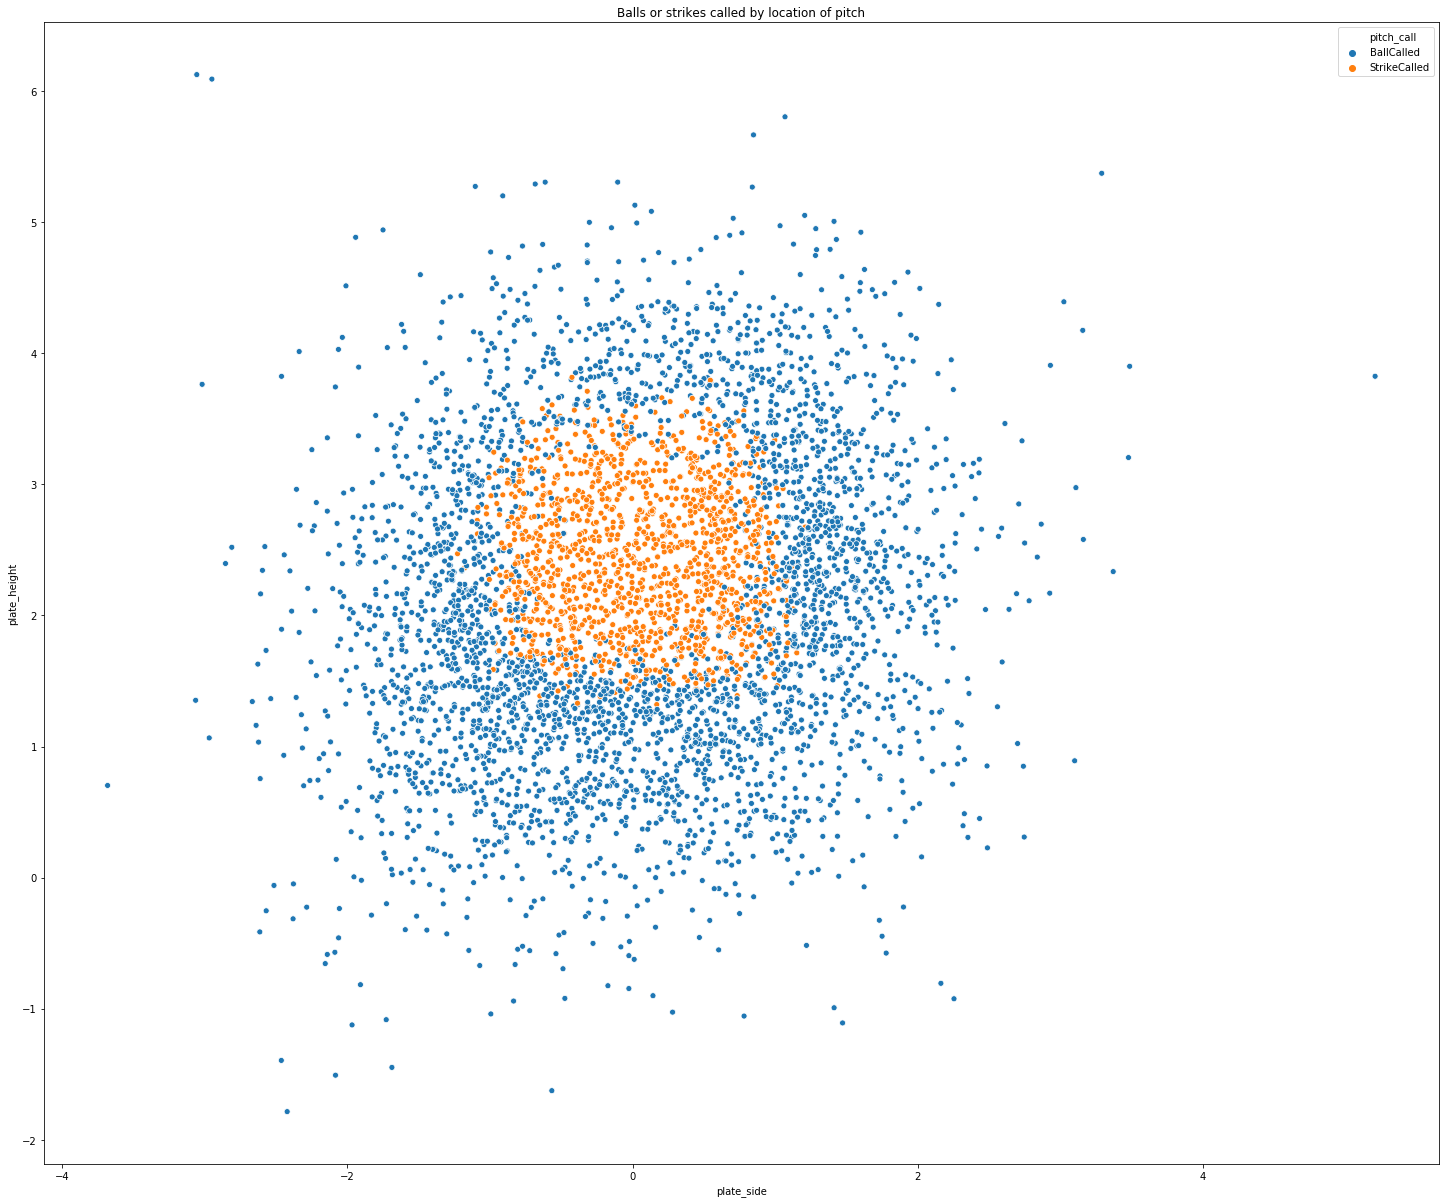

In [8]:
plt.figure(figsize=(25,21))
sns.scatterplot('plate_side', 'plate_height', data=framing_df, hue='pitch_call')
plt.title('Balls or strikes called by location of pitch')
plt.show()

Interesting. It seems like this catcher is good at framing pitches, with the orange dots being strikes called extending into areas of majority blue dots. But, it also goes the other way around. Let's clean and wrangle our data set like we did in the "Mariners Challenge" notebook to run some machine learning on it and draw some conclusions about how well this catcher frames pitches.

In [9]:
def clean_and_wrangle(df):
    
    df = df.drop(df[df['release_speed'].isnull()].index)
    df = df.drop(df[df['outs'].isnull()].index)
    df['spin_rate'].fillna(df['spin_rate'].mean(), inplace=True)
    df = df.drop(df[df['tilt'].isnull()].index)
    df = df.drop(df[df['pitch_type'].isnull()].index)
    df = df.reset_index().drop('index', axis=1)
    
    df['tilt'] = df['tilt'].map(lambda x: sum(a*int(t) for a, t in zip([3600, 60], x.split(':'))) \
                                          if ':' in x else int(x[:-5]))
    return df

In [10]:
framing_df = clean_and_wrangle(framing_df)

In [11]:
is_strike = []
for i in framing_df['pitch_call']:
    if i == 'StrikeCalled':
        is_strike.append(1)
    else: 
        is_strike.append(0)
        
framing_df['is_strike'] = is_strike

In [12]:
framing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4830 entries, 0 to 4829
Data columns (total 37 columns):
pitcher_id             4830 non-null object
pitcher_side           4830 non-null object
batter_id              4830 non-null object
batter_side            4830 non-null object
stadium_id             4830 non-null object
umpire_id              4830 non-null object
catcher_id             4830 non-null object
inning                 4830 non-null int64
top_bottom             4830 non-null int64
outs                   4830 non-null float64
balls                  4830 non-null int64
strikes                4830 non-null int64
release_speed          4830 non-null float64
vert_release_angle     4830 non-null float64
horz_release_angle     4830 non-null float64
spin_rate              4830 non-null float64
spin_axis              4830 non-null float64
tilt                   4830 non-null int64
rel_height             4830 non-null float64
rel_side               4830 non-null float64
extension 

After cleaning and getting our target variable, let's take a look at it and see if we're dealing with another imbalanced classification problem.

In [13]:
framing_df['is_strike'].value_counts()

0    3450
1    1380
Name: is_strike, dtype: int64

Yes, a similar imbalanced classification problem to the "Mariners Challenge" notebook. We'll tune an XGB Classifier model to model our data and draw some conclusions from its predictions, let's get that model ready to go.

In [14]:
framing_df['pitch_type'].value_counts()

FA    2576
SL    1029
CH     694
CU     528
XX       3
Name: pitch_type, dtype: int64

In [15]:
framing_df = framing_df.drop(framing_df[framing_df['pitch_type'] == 'XX'].index)
framing_df = pd.get_dummies(framing_df, prefix=['pitcher', 'batter', 'is'], columns=['pitcher_side', 'batter_side', 'pitch_type'])

In [16]:
X = framing_df.drop(['pitcher_id', 'batter_id', 'stadium_id', 'umpire_id', 'catcher_id', 'pitch_call', 'is_strike', 'pitch_id'], axis=1)
y = framing_df['is_strike']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=34, test_size=0.15)

In [17]:
steps = [('xgb', XGBClassifier(seed=34))]
param_grid = {'xgb__n_estimators': np.arange(10, 210, 10),
              'xgb__max_depth': np.arange(1,6,2)}
pipeline = Pipeline(steps)
cv_1 = GridSearchCV(pipeline, param_grid, cv=3)
cv_1.fit(X_train, y_train)
print(cv_1.best_params_, cv_1.best_score_)
n_estimators = cv_1.best_params_['xgb__n_estimators']
max_depth = cv_1.best_params_['xgb__max_depth']

{'xgb__max_depth': 3, 'xgb__n_estimators': 150} 0.9261326933524986


In [18]:
xgb = XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, seed=34)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

In [19]:
print(f'XGB Classifier Train Accuracy: {round(xgb.score(X_train, y_train) * 100, 2)}%')
print(f'XGB Classifier Test Accuracy: {round(xgb.score(X_test, y_test) * 100, 2)}%')
print('\n')
print('XGB Classifier Classification Report')
print(classification_report(y_test, xgb_pred))
print('\n')
print(f'XGB Classifier MCC Score: {matthews_corrcoef(y_test, xgb_pred)}')

XGB Classifier Train Accuracy: 95.95%
XGB Classifier Test Accuracy: 92.14%


XGB Classifier Classification Report
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       518
           1       0.83      0.91      0.87       207

    accuracy                           0.92       725
   macro avg       0.90      0.92      0.91       725
weighted avg       0.93      0.92      0.92       725



XGB Classifier MCC Score: 0.8149311048301918


Looks like a good model here. No signs of overfitting, it has a good recall and precision on both classes, and has an excellent MCC score. To evaluate this catcher's performance on framing pitches, I'm going to use a method for determining the number of "extra strikes" this catcher either gives up or gets called for him. I sourced it from this recent blog post from DataRobot: https://blog.datarobot.com/catcher-pitch-framing-using-machine-learning-part-1

The number of extra strikes is the number of false negatives - false positives. So the number of strikes the model thought were balls, minus the number of balls the model thought were strikes. This will tell us whether or not the catcher is getting more strikes called for his pitcher by framing the ball well. If the number is positive, that means the catcher is framing up the ball well and getting more strikes called for his pitcher, and vice versa if the number is negative. Let's take a look.

In [20]:
compare_df = y_test.to_frame()
compare_df['xgb_predict'] = xgb_pred
compare_df

,is_strike,xgb_predict
1149,0,0
1537,0,0
2543,0,0
2933,0,0
4762,0,0
...,...,...
2731,1,1
3951,0,0
76,0,0
4807,1,0


In [21]:
len(compare_df[(compare_df['is_strike'] == 1) & (compare_df['xgb_predict'] == 0)]) - \
len(compare_df[(compare_df['is_strike'] == 0) & (compare_df['xgb_predict'] == 1)])

-21

His extra strikes number is negative, which means he's not framing the ball very well and getting balls called that would normally be called for strikes. -21 isn't a huge number, so he's definitely not the worst at this, but he certainly has room for improvement. That was for the entire zone, so let's take a look at each side of the zone, left and right, and see what side he's better on. Starting with the right side.

In [22]:
right_framing = framing_df[framing_df['plate_side'] > 0]

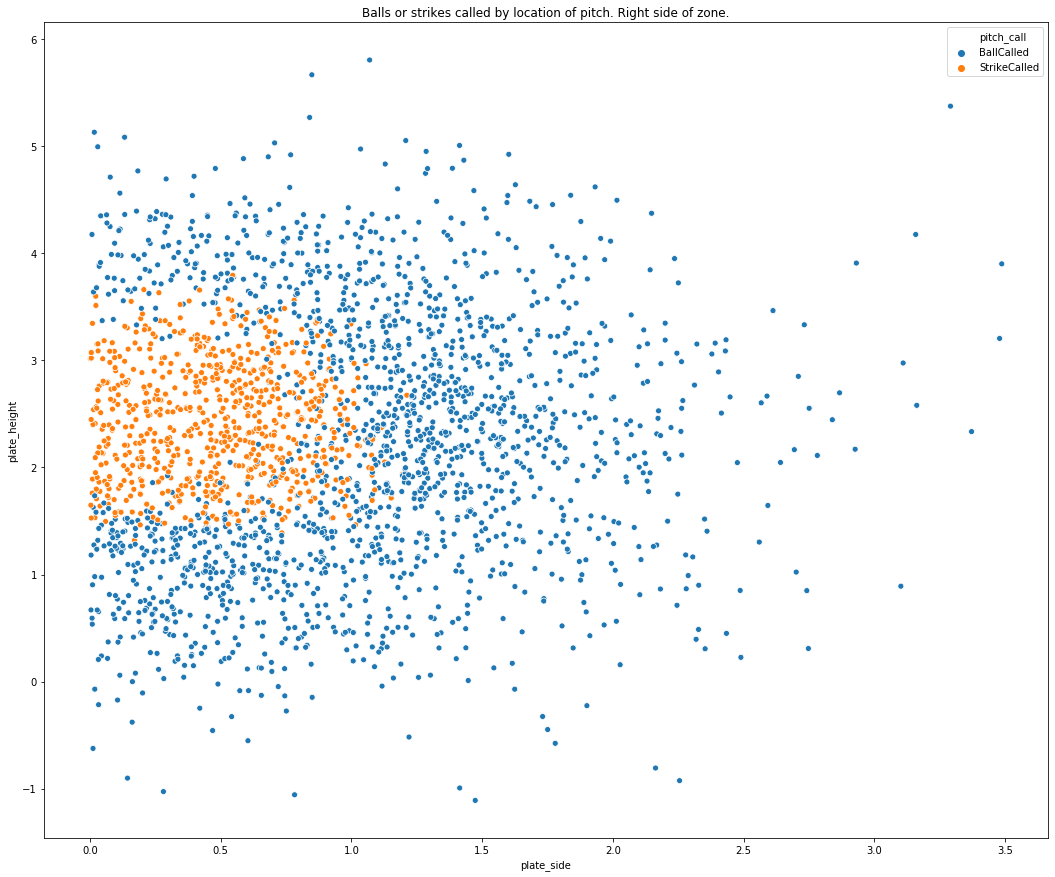

In [23]:
plt.figure(figsize=(18,15))
sns.scatterplot('plate_side', 'plate_height', data=right_framing, hue='pitch_call')
plt.title('Balls or strikes called by location of pitch. Right side of zone.')
plt.show()

In [24]:
X = right_framing.drop(['pitcher_id', 'batter_id', 'stadium_id', 'umpire_id', 'catcher_id', 'pitch_call', 'is_strike', 'pitch_id'], axis=1)
y = right_framing['is_strike']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=34, test_size=0.15)

In [25]:
right_pred = xgb.predict(X_test)

In [26]:
right_compare_df = y_test.to_frame()
right_compare_df['right_predict'] = right_pred
right_compare_df

,is_strike,right_predict
1859,1,1
504,0,0
2136,0,0
3876,0,0
1988,1,1
...,...,...
924,0,0
1113,0,0
2585,0,0
2448,0,0


In [27]:
len(right_compare_df[(right_compare_df['is_strike'] == 1) & (right_compare_df['right_predict'] == 0)]) - \
len(right_compare_df[(right_compare_df['is_strike'] == 0) & (right_compare_df['right_predict'] == 1)])

-10

Still negative, which isn't good. Let's take a look att he left side and see if its the same as the right side.

In [28]:
left_framing = framing_df[framing_df['plate_side'] < 0]

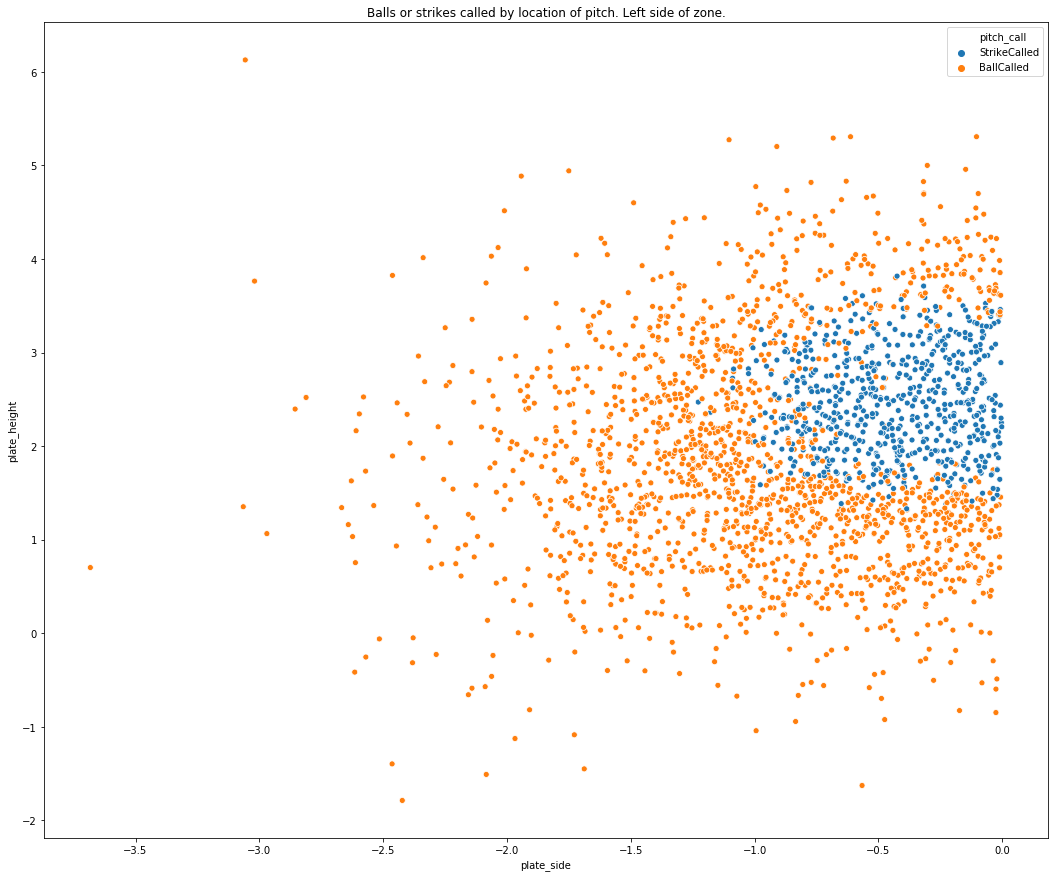

In [29]:
plt.figure(figsize=(18,15))
sns.scatterplot('plate_side', 'plate_height', data=left_framing, hue='pitch_call')
plt.title('Balls or strikes called by location of pitch. Left side of zone.')
plt.show()

In [30]:
X = left_framing.drop(['pitcher_id', 'batter_id', 'stadium_id', 'umpire_id', 'catcher_id', 'pitch_call', 'is_strike', 'pitch_id'], axis=1)
y = left_framing['is_strike']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=34, test_size=0.15)

In [31]:
left_pred = xgb.predict(X_test)

In [32]:
left_compare_df = y_test.to_frame()
left_compare_df['left_predict'] = left_pred
left_compare_df

,is_strike,left_predict
616,1,0
746,1,1
3747,1,1
1019,0,0
513,0,0
...,...,...
981,1,1
1136,0,0
737,0,0
2587,0,0


In [33]:
len(left_compare_df[(left_compare_df['is_strike'] == 1) & (left_compare_df['left_predict'] == 0)]) - \
len(left_compare_df[(left_compare_df['is_strike'] == 0) & (left_compare_df['left_predict'] == 1)])

-5

Less negative, which means this catcher does a slightly better job framing up pitches on the left side of the zone than the right side of the zone. What about from righty or lefty pitchers? Let's take a look at those data points and see who he's better for framing the ball for.

In [34]:
rp_framing = framing_df[framing_df['pitcher_Right'] == 1]

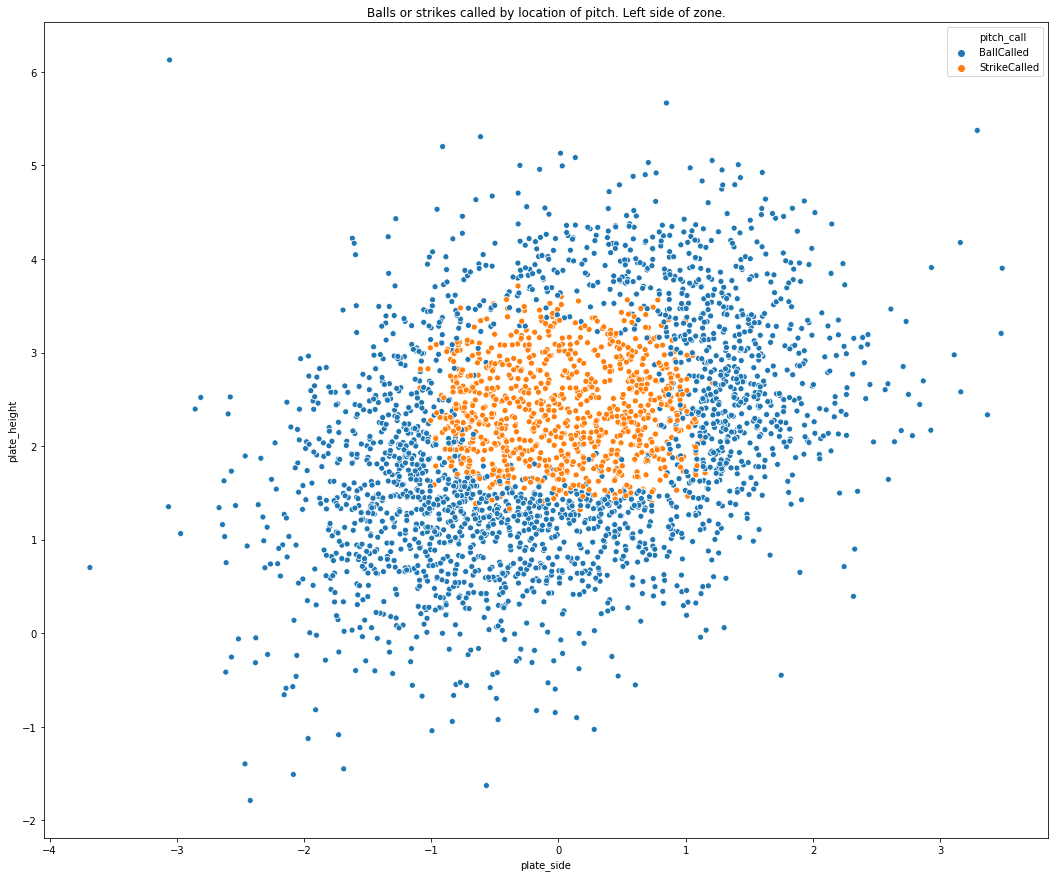

In [35]:
plt.figure(figsize=(18,15))
sns.scatterplot('plate_side', 'plate_height', data=rp_framing, hue='pitch_call')
plt.title('Balls or strikes called by location of pitch. Left side of zone.')
plt.show()

In [36]:
X = rp_framing.drop(['pitcher_id', 'batter_id', 'stadium_id', 'umpire_id', 'catcher_id', 'pitch_call', 'is_strike', 'pitch_id'], axis=1)
y = rp_framing['is_strike']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=34, test_size=0.15)

In [37]:
rp_pred = xgb.predict(X_test)

In [38]:
rp_compare_df = y_test.to_frame()
rp_compare_df['rp_predict'] = rp_pred
rp_compare_df

,is_strike,rp_predict
312,1,1
4551,0,0
2985,1,1
1986,0,0
1426,1,1
...,...,...
1031,0,0
2287,0,0
1250,1,1
2041,1,1


In [39]:
len(rp_compare_df[(rp_compare_df['is_strike'] == 1) & (rp_compare_df['rp_predict'] == 0)]) - \
len(rp_compare_df[(rp_compare_df['is_strike'] == 0) & (rp_compare_df['rp_predict'] == 1)])

-9

Similar number to the right side of the zone, let's take a look at the lefties.

In [40]:
lp_framing = framing_df[framing_df['pitcher_Left'] == 1]

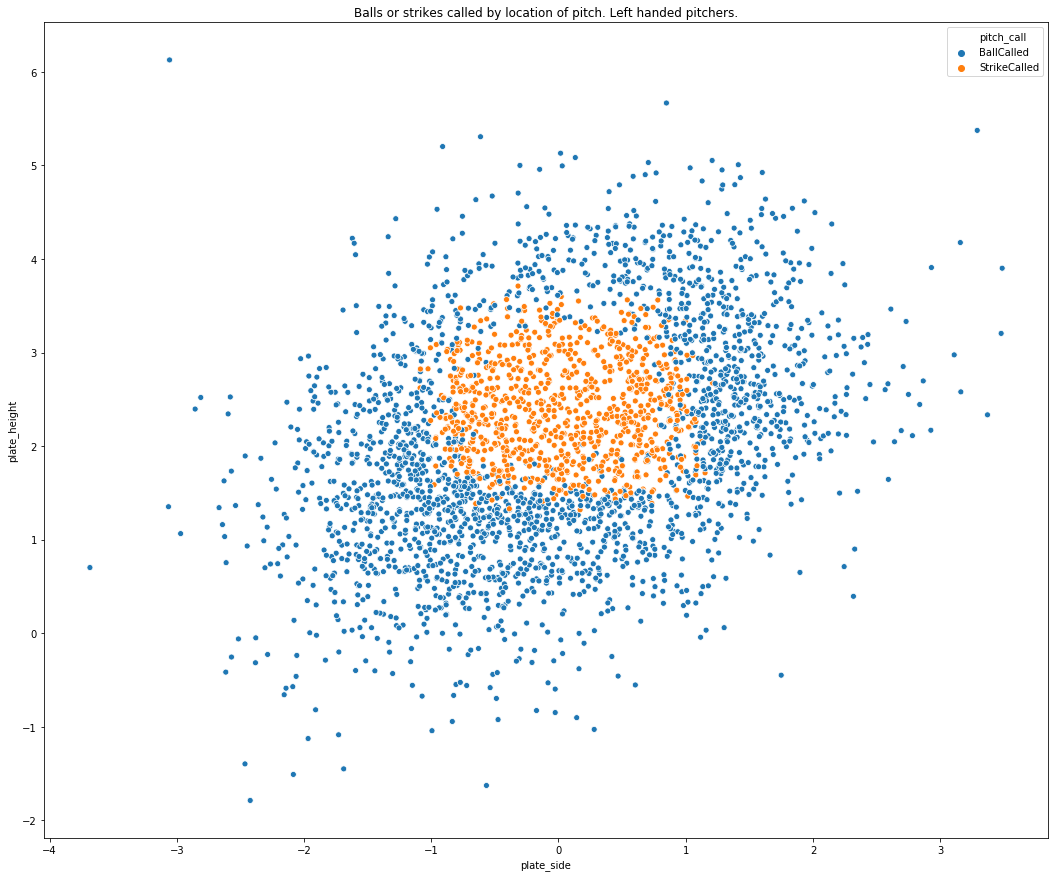

In [41]:
plt.figure(figsize=(18,15))
sns.scatterplot('plate_side', 'plate_height', data=rp_framing, hue='pitch_call')
plt.title('Balls or strikes called by location of pitch. Left handed pitchers.')
plt.show()

In [42]:
X = lp_framing.drop(['pitcher_id', 'batter_id', 'stadium_id', 'umpire_id', 'catcher_id', 'pitch_call', 'is_strike', 'pitch_id'], axis=1)
y = lp_framing['is_strike']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=34, test_size=0.15)

In [43]:
rp_pred = xgb.predict(X_test)

In [44]:
rp_compare_df = y_test.to_frame()
rp_compare_df['rp_predict'] = rp_pred
rp_compare_df

,is_strike,rp_predict
98,0,0
4522,0,0
1661,0,0
913,0,0
2131,0,0
...,...,...
4703,0,0
1038,0,0
1788,0,0
2208,0,0


In [45]:
len(rp_compare_df[(rp_compare_df['is_strike'] == 1) & (rp_compare_df['rp_predict'] == 0)]) - \
len(rp_compare_df[(rp_compare_df['is_strike'] == 0) & (rp_compare_df['rp_predict'] == 1)])

-4

Smaller number, similar to the left side of the zone. This catcher is better at framing pitches on the left side of the zone from left handed pitchers. He could be good to bring in for lefty specialist type pitchers, for throwing inside to left handed batters or low and away from right handed batters. Overall not a bad catcher, but definitely has room for improvement.